In [1]:
import pandas as pd
import numpy as np
import tqdm
import lightgbm as lgb
from  datetime import datetime, timedelta

### Import and make dataset

In [106]:
tweets = pd.read_json("/Users/sam/Documents/Masters/Data_Systems_Project/Locations/user_locations.json")

In [111]:
#location
splitted=tweets["user_location"].str.split(", ", n = 1, expand = True)
tweets["state"] = splitted[1]
tweets["city"] = splitted[0]
tweets = tweets.drop(columns=['user_location', 'id', 'text', 'coordinates', 'lang', 'place'])

#date
def split(x):
    x = str(x).split()[0]
    return x
tweets['created_at'] = tweets['created_at'].map(split)
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format="%Y-%m-%d")

In [113]:
grouped = tweets.groupby(['created_at','state', 'city']).size().reset_index(name='counts')
grouped = grouped[grouped.counts>5]

In [114]:
protest = pd.read_csv('ACLEDNeatAdress.csv')
protest['protest'] = 1
protest = protest.rename(columns={"EVENT_DATE": "created_at", "state2": "state", 'place': 'city'})
protest['created_at'] = pd.to_datetime(protest['created_at'], format="%Y-%m-%d")
protest = protest.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'LATITUDE', 'LONGITUDE', 'road'])

In [115]:
grouped['created_at'] = grouped['created_at'].astype(str)
protest['created_at'] = protest['created_at'].astype(str)

merged = pd.merge(grouped, protest,  how='left', on=['created_at', 'state', 'city'])
merged = merged.fillna(0)

### LightGBM


In [116]:
merged['created_at'] = pd.to_datetime(merged['created_at'], format="%Y-%m-%d")
def george(x):
    if x > pd.to_datetime('2020-05-24', format="%Y-%m-%d"):
        output = 1
    else:
        output = 0
    return output
merged['george'] = merged['created_at'].map(george)

In [117]:
merged["state"] = merged["state"].astype('category')
merged['state'] = merged['state'].cat.codes.astype("int16")

merged["city"] = merged["city"].astype('category')
merged['city'] = merged['city'].cat.codes.astype("int16")

merged["created_at"] = merged["created_at"].astype('category')
merged['created_at'] = merged['created_at'].cat.codes.astype("int16")

merged.protest = merged.protest.astype(int)
merged.counts = merged.counts.astype(int)

merged.tail(3)

,created_at,state,city,counts,protest,george
31745,38,283,1841,6,0,1
31746,38,295,2939,61,1,1
31747,38,302,2070,6,0,1


### feauture creation

In [118]:
merged.index.name = 'index'
merged = merged.sort_values(by=['city', 'created_at'], ascending=True).reset_index(drop=True)

In [119]:
#lagged values
merged['lag_1'] = merged[["city","counts"]].groupby("city")["counts"].shift(1)
merged['lag_2'] = merged[["city","counts"]].groupby("city")["counts"].shift(2)
merged['lag_3'] = merged[["city","counts"]].groupby("city")["counts"].shift(3)
merged['lag_7'] = merged[["city","counts"]].groupby("city")["counts"].shift(7)

In [120]:
#rolling mean
merged['RM3'] = merged[["city","counts"]].groupby("city")["counts"].transform(lambda x: x.rolling(3).mean())
merged['RM7'] = merged[["city","counts"]].groupby("city")["counts"].transform(lambda x: x.rolling(7, min_periods=5).mean())

In [121]:
merged['SD3'] = merged[["city","counts"]].groupby("city")["counts"].transform(lambda x: x.rolling(3).std())
merged['SD7'] = merged[["city","counts"]].groupby("city")["counts"].transform(lambda x: x.rolling(7, min_periods=5).std())

#### Model

In [122]:
#train and test set
y_var = ['protest']
trainCols = merged.columns[~merged.columns.isin(y_var)]
X_train = merged[trainCols]
y_train = merged["protest"]

catFeats = ['created_at', 'state', 'city', 'george']

In [123]:
valid_count = int(0.1*X_train.shape[0])

In [124]:
validInds = np.random.choice(X_train.index.values, size=(valid_count), replace = False)
#validation
trainInds = np.setdiff1d(X_train.index.values, validInds)

In [125]:
trainData = lgb.Dataset(X_train.loc[trainInds], label = y_train.loc[trainInds], categorical_feature = catFeats, free_raw_data = False)

validData = lgb.Dataset(X_train.loc[validInds], label = y_train.loc[validInds], categorical_feature = catFeats, free_raw_data = False)

In [132]:
param = {'num_leaves': merged.city.nunique(), 
'objective': 'binary',
'learning_rate':0.03,
'metric': 'rmse'}
m_lgb = lgb.train(param, trainData, valid_sets = [validData], verbose_eval = 20)

[LightGBM] [Info] Number of positive: 2038, number of negative: 26536
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 28574, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071324 -> initscore=-2.566533
[LightGBM] [Info] Start training from score -2.566533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [130]:
merged.city.nunique()

3872

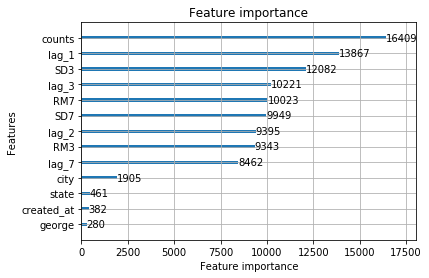

In [133]:
lgb.plot_importance(m_lgb, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='split', max_num_features=None, ignore_zero=True, figsize=None, dpi=None, grid=True, precision=3)

In [108]:
del merged

In [109]:
del protest

In [110]:
del grouped